In [24]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

import numpy as np

import tensorflow_probability.substrates.jax as tfp

import matplotlib.pyplot as plt

In [25]:
# fishnets functions

from typing import Sequence, Any
Array = Any

import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn

def fill_diagonal(a, val):
  assert a.ndim >= 2
  i, j = jnp.diag_indices(min(a.shape[-2:]))
  return a.at[..., i, j].set(val)


def construct_fisher_matrix_single(outputs):
    Q = tfp.math.fill_triangular(outputs)
    middle = jnp.diag(jnp.triu(Q) - nn.softplus(jnp.triu(Q)))
    padding = jnp.zeros(Q.shape)

    L = Q - fill_diagonal(padding, middle)

    return jnp.einsum('...ij,...jk->...ik', L, jnp.transpose(L, (1, 0))) + jnp.eye(n_params)




class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.swish(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x

# load data

In [26]:
cd /home/makinen/repositories/fishnets_for_degenerates/

/home/makinen/repositories/fishnets_for_degenerates


In [27]:
data = np.load('camb_TT_secret_params.npy')
theta_ = jax.device_put(data[:, :6])
data = jax.device_put(jnp.arcsinh(data)[:, 6:][:, ::4]) # take every fourth bin (for now)

In [28]:
data.shape

(10000, 513)

In [7]:
key = jax.random.PRNGKey(0)

n_params = 6
n_outputs = int(n_params + int(n_params * (n_params + 1)) // 2)

theta_fid = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

model = MLP([500,128,128,n_outputs])

w = model.init(key, jnp.ones((513)))

outs = model.apply(w, jnp.ones((513)))

In [8]:
outs.shape

(27,)

In [9]:
@jax.jit
def kl_loss(w, x_batched, theta_batched):

    def fn(x, theta):
       outputs = model.apply(w, x)
       t = outputs[:n_params]
       f_cholesky = outputs[n_params:]
       F = construct_fisher_matrix_single(f_cholesky)

       # score jump step
       mle = jnp.einsum('jk,k->j', jnp.linalg.inv(F), t) + theta_fid

       return mle, F
    
    mle,F = jax.vmap(fn)(x_batched, theta_batched)

    return -jnp.mean(-0.5 * jnp.einsum('ij,ij->i', (theta_batched - mle), \
                                             jnp.einsum('ijk,ik->ij', F, (theta_batched - mle))) \
                                                  + 0.5*jnp.log(jnp.linalg.det(F)), axis=0)

In [10]:
from tqdm import tqdm
import optax
tx = optax.adam(learning_rate=1e-4)
opt_state = tx.init(w)
loss_grad_fn = jax.value_and_grad(kl_loss)


batch_size = 100
epochs = 100

w = w

losses = []

In [11]:
from tqdm import tqdm
batch_size = 100
epochs = 500

key = jax.random.PRNGKey(99)

pbar = tqdm(range(epochs), leave=True, position=0)

for j in pbar:
  key,rng = jax.random.split(key)

  for i in range(len(data) // batch_size):
    x_samples = data[batch_size*i:(batch_size*(i+1))]
    y_samples = theta_[batch_size*i:(batch_size*(i+1))]

    loss_val, grads = loss_grad_fn(w, x_samples, y_samples)
    updates, opt_state = tx.update(grads, opt_state)
    w = optax.apply_updates(w, updates)

    #if i % 10 == 0:

    #  val_loss, _ = loss_grad_fn(w, X_test, y_test)
      #print('loss step {}: '.format(i), loss_val)
      #print('val loss step {}: '.format(i), val_loss_val)
      
  losses.append(loss_val)
  #val_losses.append(val_loss)
  pbar.set_description('epoch loss %d: %.4f'%(j, loss_val))

epoch loss 13: -7.9310:   3%|▎         | 14/500 [00:30<14:19,  1.77s/it]

KeyboardInterrupt: 

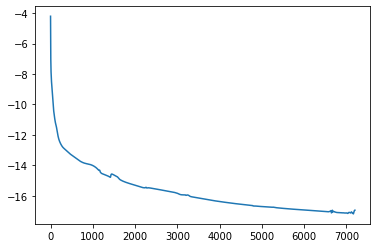

In [ ]:
plt.plot(losses)

In [ ]:
def get_mle_F(x):
    outputs = model.apply(w, x)
    t = outputs[:n_params]
    f_cholesky = outputs[n_params:]
    F = construct_fisher_matrix_single(f_cholesky)

    mle = jnp.einsum('jk,k->j', jnp.linalg.inv(F), t) + theta_fid

    return mle, F

In [ ]:
mle_pred,F_pred = jax.vmap(get_mle_F)(data[-3000:])

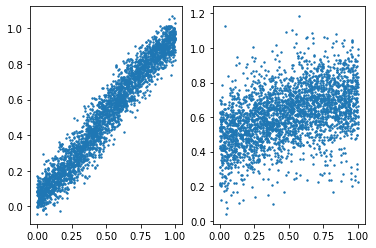

In [ ]:
plt.subplot(121)
plt.scatter(theta_[-3000:, 0], mle_pred[:, 0], s=2)
plt.subplot(122)
plt.scatter(theta_[-3000:, 1], mle_pred[:, 3], s=2)

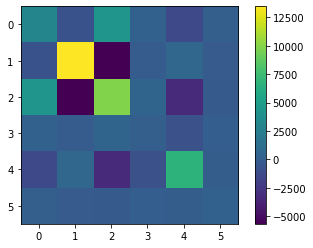

In [ ]:
plt.imshow(F_pred.mean(0))
plt.colorbar()

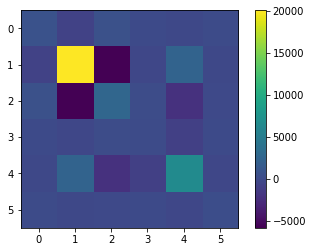

In [ ]:
plt.imshow(F_pred[59])
plt.colorbar()

In [ ]:
import cloudpickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [ ]:
outdir = "/data80/makinen/degenerate_fishnets/"

save_obj(losses, outdir + "losses")
save_obj(w, "network_w")

np.save(outdir + "mle_pred", mle_pred)
np.save(outdir + "F_pred", F_pred)

In [12]:
# load stuff
outdir = "/data80/makinen/degenerate_fishnets/"

mle_pred = np.load(outdir + "mle_pred.npy")
F_pred = np.load(outdir + "F_pred.npy")

In [29]:
theta_true = theta_[-3000:]

In [14]:
from chainconsumer import ChainConsumer


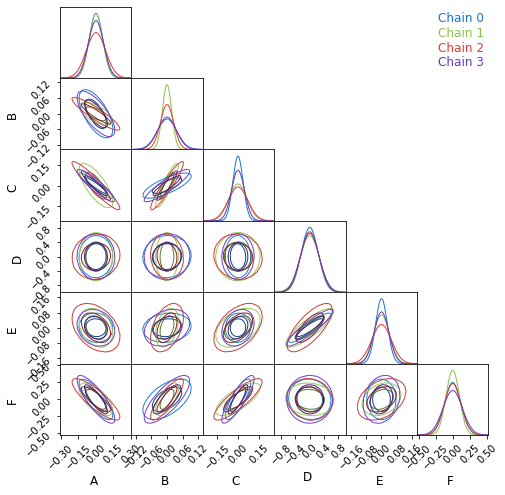

In [22]:
cs = ChainConsumer()

for i in [3, 59, 300, 2000]:


    cs.add_covariance(np.zeros((6,)), np.linalg.inv(F_pred[i]), parameters=['A', 'B', 'C', 'D', 'E', 'F']) #, color=corner_colors[0])

        #cs.configure(linestyles=["-", "-", "-"], linewidths=[1.0, 1.0, 1.0], usetex=False,
        #        shade=[True, True, False], shade_alpha=[0.7, 0.6, 0.], tick_font_size=8, sigma2d=True)
        
cs.plotter.plot((7,7))
    
plt.show()

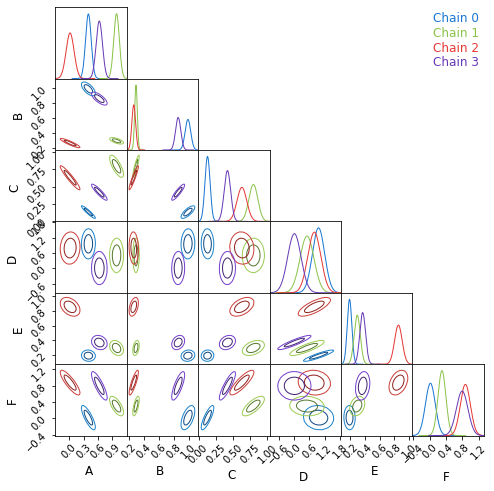

In [31]:
cs = ChainConsumer()

for i in [3, 59, 300, 2000]:


    cs.add_covariance(theta_true[i], np.linalg.inv(F_pred[i]), parameters=['A', 'B', 'C', 'D', 'E', 'F']) #, color=corner_colors[0])

        #cs.configure(linestyles=["-", "-", "-"], linewidths=[1.0, 1.0, 1.0], usetex=False,
        #        shade=[True, True, False], shade_alpha=[0.7, 0.6, 0.], tick_font_size=8, sigma2d=True)
        
cs.plotter.plot((7,7))
    
plt.show()

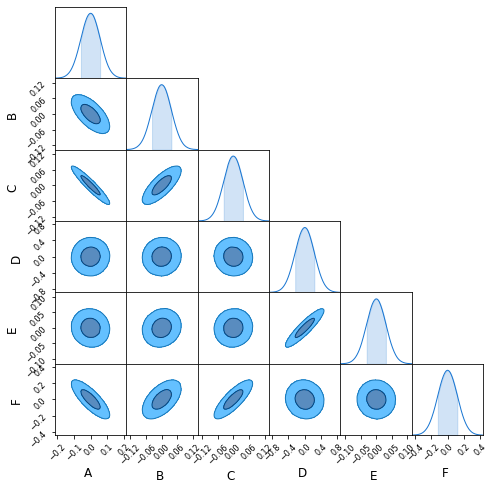

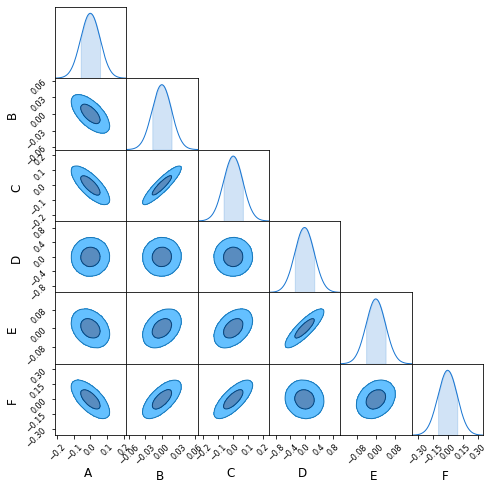

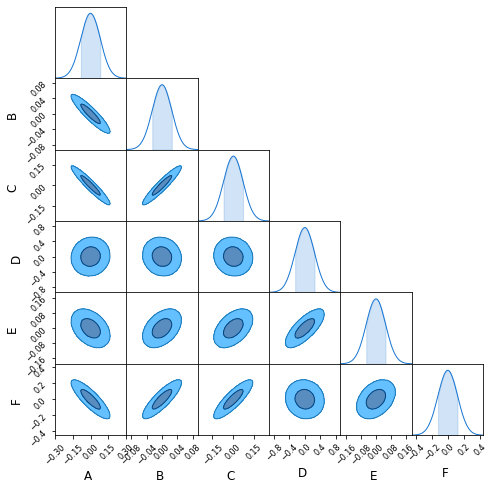

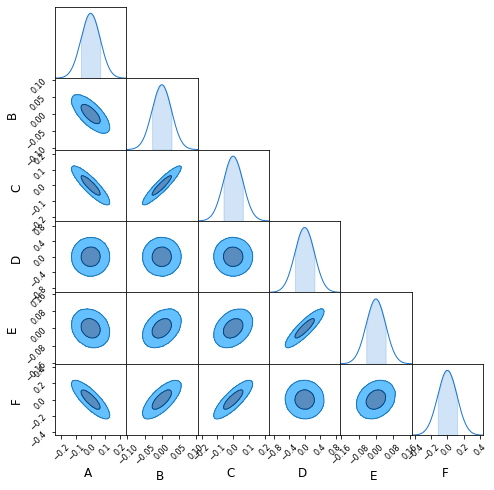

In [19]:
for i in [3, 59, 300, 2000]:

        cs = ChainConsumer()
        cs.add_covariance(np.zeros((6,)), np.linalg.inv(F_pred[i]), parameters=['A', 'B', 'C', 'D', 'E', 'F'], name='fishnets') #, color=corner_colors[0])



        cs.configure(linestyles=["-", "-", "-"], linewidths=[1.0, 1.0, 1.0], usetex=False,
                shade=[True, True, False], shade_alpha=[0.7, 0.6, 0.], tick_font_size=8, sigma2d=True)
        cs.plotter.plot((7,7))
        plt.show()